## Import dependencies

In [ ]:
# working with data
import numpy as np
import pandas as pd

# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

# base
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
)

# preprocessing and pipeline (workflow)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    precision_score, 
    recall_score,
    f1_score,
)

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


## Import cleaned data

In [2]:
df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# drop id column, not relevant for prediction
df = df.drop("id", axis=1)

In [5]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Preprocessing

### Split data into train and test

In [6]:
X = df.drop(columns=["stroke"])      
y = df["stroke"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)      
X_train.shape, X_test.shape

((4088, 10), (1022, 10))

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4088 entries, 301 to 2845
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                3922 non-null   float64
 9   smoking_status     4088 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB


### Separate categorical and numerical features

- preferred to do it manually

In [9]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [10]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [18]:
numeric_features =["age", "avg_glucose_level", "bmi"]
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type',  'smoking_status']
categorical_features, numeric_features

(['gender',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi'])

### Define transformers pipelines

### Standard transformer

In [28]:
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                                      ("scaler", StandardScaler().set_output(transform="pandas"))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                               ]).set_output(transform="pandas")
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

### Transformer for decision trees

⚠️ Tree-based models don't require data to be scaled!      

Tree based models are non-linear and are not distance based models. Remember to create a transformation pipeline without scaling! 

In [27]:
categorical_transformer_tree = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])

numeric_transformer_tree = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3))])

preprocessor_tree = ColumnTransformer(transformers=[("num", numeric_transformer_tree, numeric_features),       # passthrough -> does nothing, no scaling
                                                    ("cat", categorical_transformer_tree, categorical_features)
                                                    ]).set_output(transform="pandas")
preprocessor_tree

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

## Models

### Create a dataframe to keep scores

In [29]:
scores_df = pd.DataFrame(columns=[
    "model_name",
    "F1",
    "Precision",
    "Recall",
])

scores_df

,model_name,F1,Precision,Recall


In [30]:
def add_row(df, y_test=None, y_pred=None, model_name=None):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    new_row = {
        "model_name": model_name,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
    }

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df

### Train and evaluate different models

#### Logistic regression

##### Initialize model and build pipeline

In [33]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("model", lr_model)
                              ])
pipeline_lr

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

##### Train and evaluate model

In [34]:
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

class_labels = pipeline_lr.named_steps['model'].classes_

print(classification_report(y_test, y_pred_lr))

pd.DataFrame(confusion_matrix(y_test, y_pred_lr),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

,0,1
0,972,0
1,50,0


 Note &rarr; average= 
- 'macro' for equal weight for each type of the predicted variable
- 'weighted' if some types of the predicted variable are much more common than others to account for class imbalance

##### Save scores

In [35]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_lr, model_name="Logistic Regression")
scores_df

c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\catal\AppData\Local\Temp\ipykernel_21144\3027274401.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076


#### KNN classifier

##### Initialize model and build pipeline

In [36]:
knn = KNeighborsClassifier()
pipeline_knn = Pipeline([("pre_process", preprocessor),
                         ("model", knn)])
pipeline_knn

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

##### Train and evaluate model

In [37]:
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)

class_labels = pipeline_knn.named_steps['model'].classes_

print(classification_report(y_test, y_pred_knn))

pd.DataFrame(confusion_matrix(y_test, y_pred_knn),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



,0,1
0,968,4
1,50,0


##### Save scores

In [38]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_knn, model_name="KNN Regression")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162


#### Naive Bayes

##### Initialize model and build pipeline

In [39]:
nb = BernoulliNB()
pipeline_nb = Pipeline([("pre_process", preprocessor),
                        ("model", nb)])
pipeline_nb

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

##### Train and evaluate model

In [40]:
pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

class_labels = pipeline_nb.named_steps['model'].classes_

print(classification_report(y_test, y_pred_nb))

pd.DataFrame(confusion_matrix(y_test, y_pred_nb),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       972
           1       0.14      0.28      0.19        50

    accuracy                           0.88      1022
   macro avg       0.55      0.60      0.56      1022
weighted avg       0.92      0.88      0.90      1022



,0,1
0,889,83
1,36,14


##### Save scores

In [41]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_nb, model_name="Naive Bayes")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562


#### SVM classifier

##### Linear Support vector classification

###### Initialize model and build pipeline

In [42]:
svm = LinearSVC()
pipeline_svm = Pipeline([("pre_process", preprocessor),
                         ("model", svm)])
pipeline_svm

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

###### Train and evaluate model

In [43]:
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)

class_labels = pipeline_svm.named_steps['model'].classes_

print(classification_report(y_test, y_pred_svm))

pd.DataFrame(confusion_matrix(y_test, y_pred_svm),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

,0,1
0,972,0
1,50,0


###### Save scores

In [44]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_svm, model_name="Linear SVC")
scores_df

c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076


##### Support vector classification with Radial basis function

###### Initialize model and build pipeline

In [45]:
svm_rbf = SVC(kernel="rbf", gamma="scale")
pipeline_svm_rbf = Pipeline([("pre_process", preprocessor),
                             ("model", svm_rbf)])
pipeline_svm_rbf

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

###### Train and evaluate model

In [46]:
pipeline_svm_rbf.fit(X_train, y_train)
y_pred_svm_rbf = pipeline_svm_rbf.predict(X_test)

class_labels = pipeline_svm_rbf.named_steps['model'].classes_

print(classification_report(y_test, y_pred_svm_rbf))

pd.DataFrame(confusion_matrix(y_test, y_pred_svm_rbf),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

,0,1
0,972,0
1,50,0


###### Save scores

In [47]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_svm_rbf, model_name="SVC with radial basis")
scores_df

c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076
4,SVC with radial basis,0.927228,0.904546,0.951076


#### Decision tree

##### Initialize model and build pipeline

In [48]:
dtree = DecisionTreeClassifier(random_state=42)
pipeline_dtree = Pipeline([("pre_process", preprocessor_tree),
                           ("model", dtree)])
pipeline_dtree

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

##### Train and evaluate model

In [49]:
pipeline_dtree.fit(X_train, y_train)
y_pred_dt = pipeline_dtree.predict(X_test)

class_labels = pipeline_dtree.named_steps['model'].classes_

print(classification_report(y_test, y_pred_dt))

pd.DataFrame(confusion_matrix(y_test, y_pred_dt),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       972
           1       0.11      0.16      0.13        50

    accuracy                           0.90      1022
   macro avg       0.53      0.55      0.54      1022
weighted avg       0.91      0.90      0.90      1022



,0,1
0,907,65
1,42,8


##### Save scores

In [50]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_dt, model_name="Decision Tree")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076
4,SVC with radial basis,0.927228,0.904546,0.951076
5,Decision Tree,0.904465,0.914346,0.895303


#### Random forest

##### Initialize model and build pipeline

In [51]:
rf = RandomForestClassifier(random_state=42)
pipeline_rf = Pipeline([("pre_process", preprocessor_tree),
                         ("model", rf)])
pipeline_rf

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

##### Train and evaluate model

In [52]:
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

class_labels = pipeline_rf.named_steps['model'].classes_

print(classification_report(y_test, y_pred_rf))

pd.DataFrame(confusion_matrix(y_test, y_pred_rf),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



,0,1
0,970,2
1,50,0


##### Save scores

In [53]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_rf, model_name="Random Forest")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076
4,SVC with radial basis,0.927228,0.904546,0.951076
5,Decision Tree,0.904465,0.914346,0.895303
6,Random Forest,0.926249,0.904455,0.949119


#### AdaBoost

You do not need to scale numerical data for AdaBoostClassifier, especially when using DecisionTreeClassifier as the base estimator (which is the default)

##### Initialize model and build pipeline

In [54]:
ada_boost = AdaBoostClassifier(random_state=42)
pipeline_ada_boost = Pipeline([("pre_process", preprocessor_tree),
                               ("model", ada_boost)])
pipeline_ada_boost

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

##### Train and evaluate model

In [55]:
pipeline_ada_boost.fit(X_train, y_train)
y_pred_ada = pipeline_ada_boost.predict(X_test)

class_labels = pipeline_ada_boost.named_steps['model'].classes_

print(classification_report(y_test, y_pred_ada))

pd.DataFrame(confusion_matrix(y_test, y_pred_ada),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

,0,1
0,972,0
1,50,0


##### Save scores

In [56]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_ada, model_name="AdaBoost")
scores_df

c:\Users\catal\Documents\constructor\Complete_Project_Stroke\stroke-project\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076
4,SVC with radial basis,0.927228,0.904546,0.951076
5,Decision Tree,0.904465,0.914346,0.895303
6,Random Forest,0.926249,0.904455,0.949119
7,AdaBoost,0.927228,0.904546,0.951076


#### Gradient Boosting

##### Initialize model and build pipeline

In [57]:
gbm = GradientBoostingClassifier(random_state=42)
pipeline_gbm = Pipeline([("pre_process", preprocessor_tree),
                         ("model", gbm)])
pipeline_gbm

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

##### Train and evaluate model

In [58]:
pipeline_gbm.fit(X_train, y_train)
y_pred_gbm = pipeline_gbm.predict(X_test)

class_labels = pipeline_gbm.named_steps['model'].classes_

print(classification_report(y_test, y_pred_gbm))

pd.DataFrame(confusion_matrix(y_test, y_pred_gbm),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.17      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.56      0.51      0.50      1022
weighted avg       0.91      0.95      0.93      1022



,0,1
0,967,5
1,49,1


##### Save scores

In [59]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_gbm, model_name="Gradient Boosting")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076
4,SVC with radial basis,0.927228,0.904546,0.951076
5,Decision Tree,0.904465,0.914346,0.895303
6,Random Forest,0.926249,0.904455,0.949119
7,AdaBoost,0.927228,0.904546,0.951076
8,Gradient Boosting,0.926990,0.913361,0.947162


#### XGBoost

##### Initialize model and build pipeline

In [65]:
xgb = XGBClassifier(random_state=42)
pipeline_xgb = Pipeline([("pre_process", preprocessor_tree),
                         ("model", xgb)])
pipeline_xgb

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre_process', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

⚠️ XGBoost doesn't work with string y labels &rarr; remember to label encode before fitting

In [67]:
# from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

##### Train and evaluate model

In [68]:
pipeline_xgb.fit(X_train, y_train_le)
y_pred_le = pipeline_xgb.predict(X_test)

# reverse transform predicted 0s and 1s into string labels
y_pred_xgb = le.inverse_transform(y_pred_le)

class_labels = le.classes_

print(classification_report(y_test, y_pred_xgb))

pd.DataFrame(confusion_matrix(y_test, y_pred_xgb),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.25      0.06      0.10        50

    accuracy                           0.95      1022
   macro avg       0.60      0.53      0.53      1022
weighted avg       0.92      0.95      0.93      1022



,0,1
0,963,9
1,47,3


##### Save scores

In [69]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_xgb, model_name="XGBoosting")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076
4,SVC with radial basis,0.927228,0.904546,0.951076
5,Decision Tree,0.904465,0.914346,0.895303
6,Random Forest,0.926249,0.904455,0.949119
7,AdaBoost,0.927228,0.904546,0.951076
8,Gradient Boosting,0.926990,0.913361,0.947162
9,XGBoosting,0.928939,0.919049,0.945205


### Compare model performance after one fit

In [70]:
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.927228,0.904546,0.951076
1,KNN Regression,0.925268,0.904363,0.947162
2,Naive Bayes,0.900734,0.921123,0.883562
3,Linear SVC,0.927228,0.904546,0.951076
4,SVC with radial basis,0.927228,0.904546,0.951076
5,Decision Tree,0.904465,0.914346,0.895303
6,Random Forest,0.926249,0.904455,0.949119
7,AdaBoost,0.927228,0.904546,0.951076
8,Gradient Boosting,0.926990,0.913361,0.947162
9,XGBoosting,0.928939,0.919049,0.945205


In [71]:
best_score = scores_df[scores_df["F1"] == scores_df["F1"].max()].reset_index(drop=True)
print(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")

XGBoosting got best score with an accuracy of 0.929


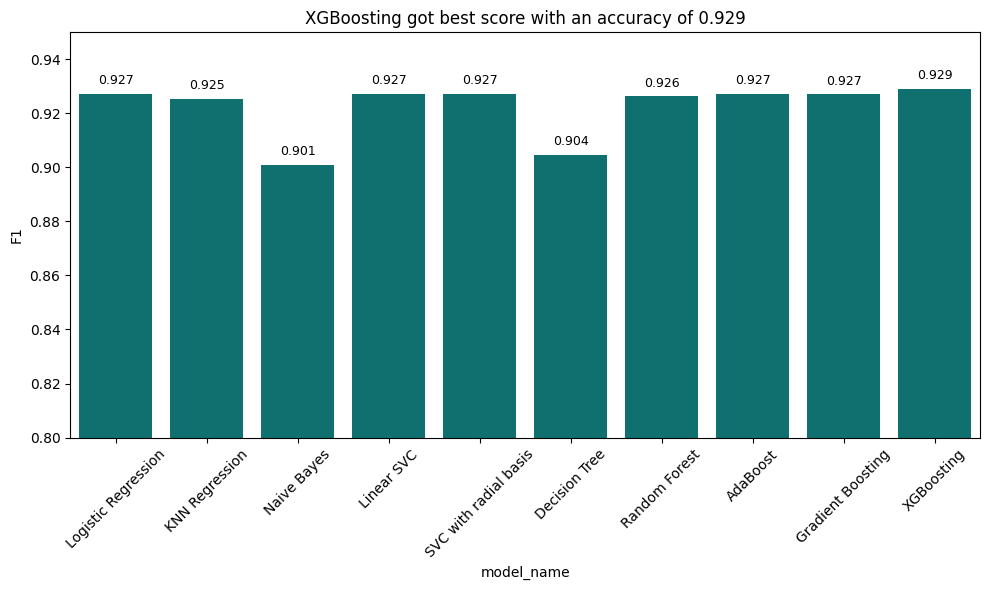

In [79]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=scores_df["model_name"], y=scores_df["F1"], color="teal")
plt.title(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.ylim(0.8, 0.95)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

### Compare model performance after cross validation

#### Calculate scores

In [80]:
scores_cv = {}
scores_cv['log_reg'] = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['knn'] = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['nb'] = cross_val_score(pipeline_nb, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm'] = cross_val_score(pipeline_svm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm_rbf'] = cross_val_score(pipeline_svm_rbf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['dtree'] = cross_val_score(pipeline_dtree, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['rf'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['ada_boost'] = cross_val_score(pipeline_ada_boost, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['gbm'] = cross_val_score(pipeline_gbm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['xgb'] = cross_val_score(pipeline_xgb, X_train, y_train_le, cv=5, scoring='f1_weighted')

In [81]:
scores_cv_df = pd.DataFrame({
    "model_name" : scores_cv.keys(),
    'F1': [round(np.mean(scores), 3) for scores in scores_cv.values()]
})

scores_cv_df

,model_name,F1
0,log_reg,0.928
1,knn,0.926
2,nb,0.902
3,svm,0.928
4,svm_rbf,0.928
5,dtree,0.914
6,rf,0.927
7,ada_boost,0.928
8,gbm,0.929
9,xgb,0.927


#### Choose best score

In [82]:
best_score_cv = scores_cv_df[scores_cv_df["F1"] == scores_cv_df["F1"].max()].reset_index(drop=True)
print(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")


gbm got best score with an accuracy of 0.929


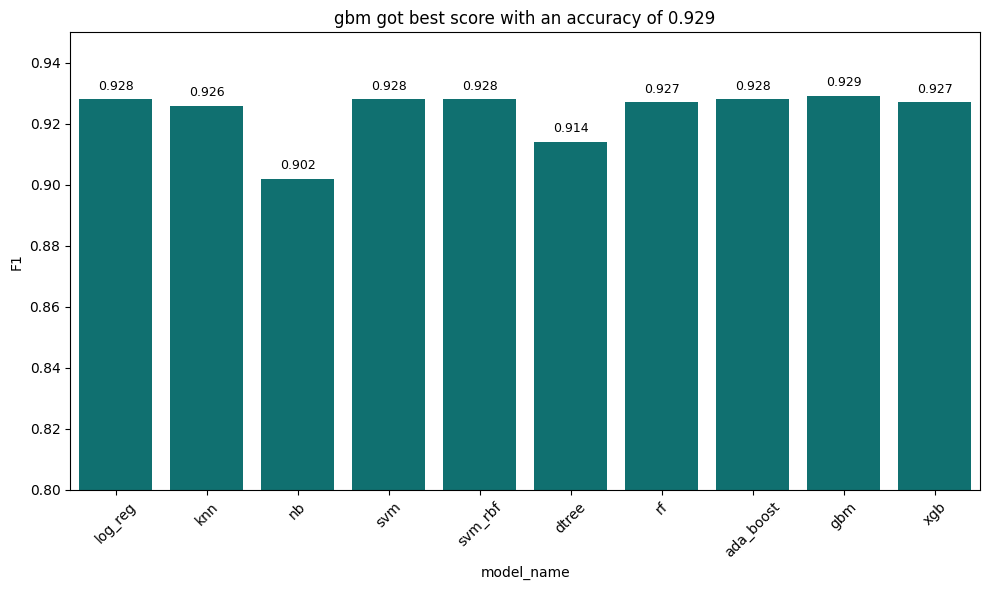

In [84]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=scores_cv_df["model_name"], y=scores_cv_df["F1"], color="teal")
plt.title(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.ylim(0.8, 0.95)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

&rarr; they are all performing very good!       
&rarr; will stick to gbm just because it doesn't need extra processing

# Conclusion

I will choose Gradient Boosting Classifier to continue :)  